In [1]:
import os
import random
import shutil
from tqdm import tqdm
import kagglehub
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Conv2D, BatchNormalization, ReLU, Add, MaxPooling2D,
    GlobalAveragePooling2D, Dense, Input, Dropout
)
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import PIL.Image

In [2]:
# Download the dataset
path = kagglehub.dataset_download("hearfool/vggface2")
print("Path to dataset files:", path)

# Parameters
NUM_CLASSES = 40
IMAGES_PER_CLASS = 200
TRAIN_RATIO = 0.8
IMG_SIZE = (112, 112)
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE

# Define directories
original_dir = os.path.join(path, "train")
output_dir = "vggface2_split"
train_dir = os.path.join(output_dir, "train")
test_dir = os.path.join(output_dir, "test")

# Create output directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get all class directories
classes = [d for d in os.listdir(original_dir) if os.path.isdir(os.path.join(original_dir, d))]

# Select 50 classes randomly
selected_classes = random.sample(classes, NUM_CLASSES)

for cls in tqdm(selected_classes, desc="Processing classes"):
    cls_path = os.path.join(original_dir, cls)
    images = [img for img in os.listdir(cls_path) if img.endswith(".jpg")]

    # Ensure we have at least 150 images
    if len(images) < IMAGES_PER_CLASS:
        print(f"Skipping class {cls} (not enough images)")
        continue

    # Randomly select 150 images
    selected_images = random.sample(images, IMAGES_PER_CLASS)

    # Split into train and test
    split_index = int(TRAIN_RATIO * IMAGES_PER_CLASS)
    train_images = selected_images[:split_index]
    test_images = selected_images[split_index:]

    # Copy to train directory
    train_cls_dir = os.path.join(train_dir, cls)
    os.makedirs(train_cls_dir, exist_ok=True)
    for img in train_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(train_cls_dir, img))

    # Copy to test directory
    test_cls_dir = os.path.join(test_dir, cls)
    os.makedirs(test_cls_dir, exist_ok=True)
    for img in test_images:
        shutil.copy(os.path.join(cls_path, img), os.path.join(test_cls_dir, img))

print("Dataset split completed.")

# Preprocessing function with Data Augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomTranslation(0.1, 0.1)
])

def preprocess_with_augmentation(features, labels):
    features = tf.cast(features, tf.float32) / 255.0  # Normalize
    features = data_augmentation(features)
    return features, labels

def load_images_from_directory(folder_path, img_size=(112, 112)):
    labels = []
    images = []
    class_names = sorted(os.listdir(folder_path))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for filename in os.listdir(class_folder):
            if filename.endswith(('.tif', '.jpg', '.png')):
                img_path = os.path.join(class_folder, filename)
                try:
                    img = PIL.Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)  # Resize image
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)
                except Exception as e:
                    print(f"Error loading image: {img_path}")
                    continue
    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

def create_tf_datasets():
    train_ds, train_labels, train_classes = load_images_from_directory(train_dir, IMG_SIZE)
    test_ds, test_labels, _ = load_images_from_directory(test_dir, IMG_SIZE)

    train_tensor_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels))
    train_tensor_ds = train_tensor_ds.map(preprocess_with_augmentation).shuffle(5000).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    test_tensor_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_labels))
    test_tensor_ds = test_tensor_ds.map(lambda x, y: (tf.cast(x, tf.float32) / 255.0, y)).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

    return train_tensor_ds, test_tensor_ds, train_classes

100%|██████████| 2.32G/2.32G [00:24<00:00, 101MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/hearfool/vggface2/versions/1


Processing classes:  92%|█████████▎| 37/40 [00:00<00:00, 44.73it/s]

Skipping class n000075 (not enough images)


Processing classes: 100%|██████████| 40/40 [00:00<00:00, 40.46it/s]


Dataset split completed.


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Load the preprocessed datasets
train_ds, test_ds, class_names = create_tf_datasets()
NUM_CLASSES = len(class_names)

# Define the DenseNet model with adjustments
def create_densenet_model(input_shape=(112, 112, 3), num_classes=NUM_CLASSES):
    # Load DenseNet121 without the top layer
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=input_shape)
    base_model.trainable = True  # Unfreeze base model for fine-tuning

    # Freeze the first 50 layers for stability
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # Add custom layers
    inputs = tf.keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)  # Pass inputs through DenseNet
    x = layers.GlobalAveragePooling2D()(x)  # Global average pooling
    x = layers.Dropout(0.5)(x)  # Dropout for regularization
    outputs = layers.Dense(num_classes, activation="softmax")(x)  # Final classification layer

    model = tf.keras.Model(inputs, outputs)
    return model

# Create the model
model = create_densenet_model()

# Compile the model with a smaller learning rate
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
checkpoint = ModelCheckpoint(
    "best_model.keras", save_best_only=True, monitor="val_accuracy", mode="max"
)
early_stopping = EarlyStopping(
    patience=5, restore_best_weights=True, monitor="val_accuracy"
)
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6
)








29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [4]:

# Train the DenseNet model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,  # Train for 20 epochs
    batch_size=16,  # Increase batch size
    callbacks=[checkpoint, early_stopping, lr_scheduler]
)

# Save the trained model
model.save("densenet_finetuned.keras")
print("DenseNet model fine-tuning completed and saved.")


Epoch 1/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 98s 26ms/step - accuracy: 0.0562 - loss: 4.4931 - val_accuracy: 0.3801 - val_loss: 2.3774 - learning_rate: 1.0000e-04
Epoch 2/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - accuracy: 0.1790 - loss: 3.2545 - val_accuracy: 0.5205 - val_loss: 1.7805 - learning_rate: 1.0000e-04
Epoch 3/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 82s 20ms/step - accuracy: 0.2737 - loss: 2.7119 - val_accuracy: 0.5955 - val_loss: 1.4860 - learning_rate: 1.0000e-04
Epoch 4/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 55s 20ms/step - accuracy: 0.3587 - loss: 2.3552 - val_accuracy: 0.6218 - val_loss: 1.3434 - learning_rate: 1.0000e-04
Epoch 5/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - accuracy: 0.4043 - loss: 2.1624 - val_accuracy: 0.6526 - val_loss: 1.2155 - learning_rate: 1.0000e-04
Epoch 6/20
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 81s 20ms/step - accuracy: 0.4154 - loss: 2.0841 - val_accuracy: 0.6821 - val_loss: 1.1383 - learning_rate: 1.0000e-04
Epoch 7/20
1560/1560 ━━━━━━━━━━━━━━━━━━━

In [6]:

# Train for 10 more epochs
history_extra = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=30,
    initial_epoch=20,
    batch_size=16,
    callbacks=[checkpoint, lr_scheduler]
)

# Save the updated model
model.save("densenet_finetuned_extended.keras")
print("DenseNet model extended training completed and saved.")


Epoch 21/30
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - accuracy: 0.6381 - loss: 1.3089 - val_accuracy: 0.7872 - val_loss: 0.7344 - learning_rate: 1.0000e-04
Epoch 22/30
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - accuracy: 0.6466 - loss: 1.2124 - val_accuracy: 0.7878 - val_loss: 0.7382 - learning_rate: 1.0000e-04
Epoch 23/30
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 56s 21ms/step - accuracy: 0.6456 - loss: 1.2541 - val_accuracy: 0.7949 - val_loss: 0.7306 - learning_rate: 1.0000e-04
Epoch 24/30
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - accuracy: 0.6617 - loss: 1.1839 - val_accuracy: 0.7962 - val_loss: 0.7149 - learning_rate: 1.0000e-04
Epoch 25/30
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step - accuracy: 0.6519 - loss: 1.1861 - val_accuracy: 0.7955 - val_loss: 0.7175 - learning_rate: 1.0000e-04
Epoch 26/30
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 82s 21ms/step - accuracy: 0.6821 - loss: 1.0958 - val_accuracy: 0.7923 - val_loss: 0.6979 - learning_rate: 1.0000e-04
Epoch 27/30
1560/1560 ━━━━━━━━━━━━

In [8]:
# Train for another 10 epochs
history_extra_2 = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=40,
    initial_epoch=30,
    batch_size=16,
    callbacks=[checkpoint, lr_scheduler]
)

# Save the updated model
model.save("densenet_finetuned_extended_v2.keras")
print("DenseNet model additional extended training completed and saved.")


Epoch 31/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 57s 21ms/step - accuracy: 0.7070 - loss: 1.0377 - val_accuracy: 0.8071 - val_loss: 0.6786 - learning_rate: 5.0000e-05
Epoch 32/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 83s 22ms/step - accuracy: 0.6888 - loss: 1.0545 - val_accuracy: 0.7994 - val_loss: 0.6753 - learning_rate: 5.0000e-05
Epoch 33/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 81s 21ms/step - accuracy: 0.7053 - loss: 1.0013 - val_accuracy: 0.8064 - val_loss: 0.6684 - learning_rate: 5.0000e-05
Epoch 34/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 55s 21ms/step - accuracy: 0.7056 - loss: 1.0222 - val_accuracy: 0.8051 - val_loss: 0.6483 - learning_rate: 5.0000e-05
Epoch 35/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step - accuracy: 0.7202 - loss: 0.9734 - val_accuracy: 0.8141 - val_loss: 0.6506 - learning_rate: 5.0000e-05
Epoch 36/40
1560/1560 ━━━━━━━━━━━━━━━━━━━━ 57s 22ms/step - accuracy: 0.7181 - loss: 0.9658 - val_accuracy: 0.8058 - val_loss: 0.6457 - learning_rate: 5.0000e-05
Epoch 37/40
1560/1560 ━━━━━━━━━━━━

In [10]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)

# Print the results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

390/390 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7915 - loss: 0.6735
Test Loss: 0.6577
Test Accuracy: 0.8045


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━

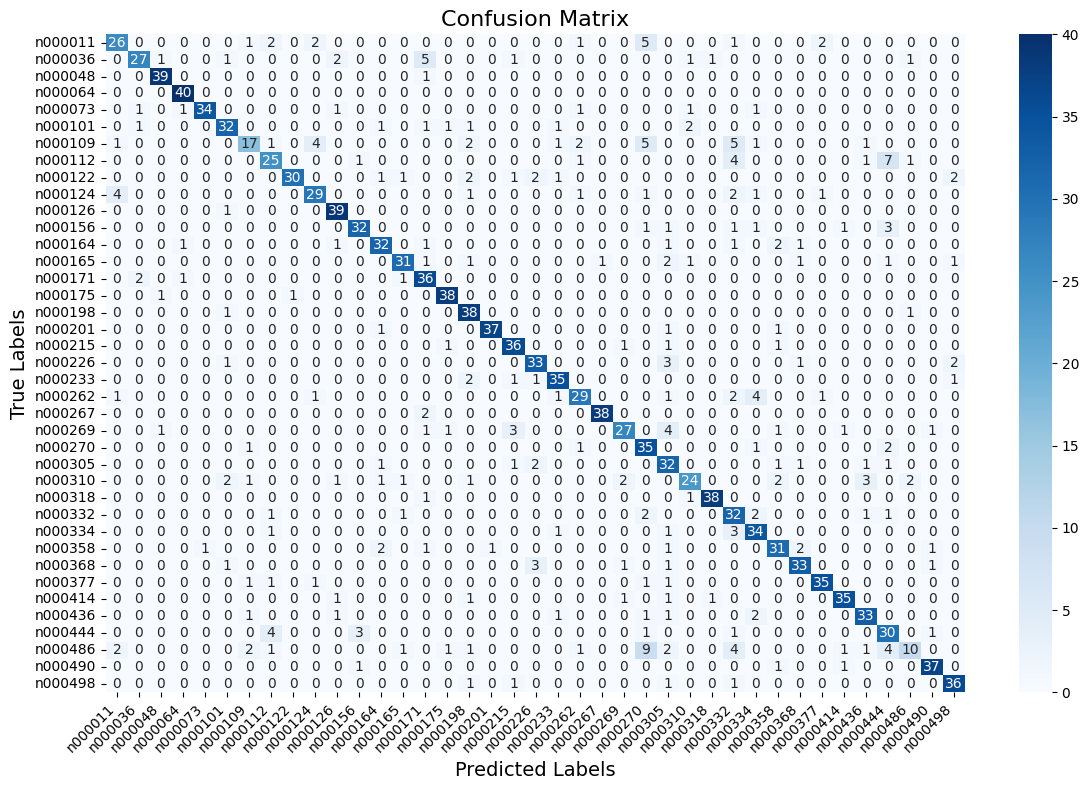

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluate model predictions on the test dataset
y_true = []
y_pred = []
y_pred_probs = []

# Iterate over the test dataset to collect predictions and true labels
for features, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(features))
    y_pred.extend(np.argmax(model.predict(features), axis=-1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_pred_probs = np.array(y_pred_probs)



# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)

# Add labels and title
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.title("Confusion Matrix", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━

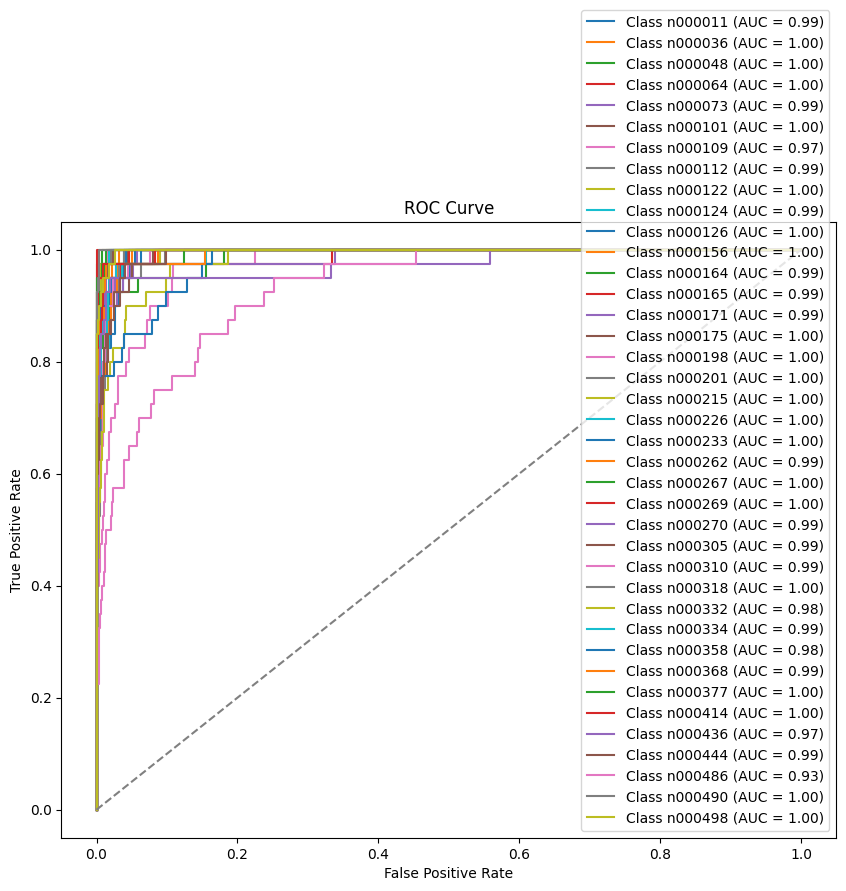

In [13]:
# Compute predictions for ROC AUC
y_true = []
y_pred_probs = []
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred_probs.extend(model.predict(images))

y_true = np.array(y_true)
y_pred_probs = np.array(y_pred_probs)

# Compute ROC AUC for each class
fpr = {}
tpr = {}
roc_auc = {}
for i in range(len(class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC Curve for each class
plt.figure(figsize=(10, 8))
for i in range(len(class_names)):
    plt.plot(fpr[i], tpr[i], label=f"Class {class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Add random chance line
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


In [14]:
# Compute overall macro-average ROC AUC
macro_roc_auc = roc_auc_score(y_true, y_pred_probs, multi_class="ovr", average="macro")
print(f"Macro-Average ROC AUC: {macro_roc_auc:.2f}")

# Merge histories from all training phases
def combine_histories(*histories):
    combined_history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for hist in histories:
        for key in combined_history.keys():
            combined_history[key].extend(hist.history[key])
    return combined_history

# Combine histories
full_history = combine_histories(history, history_extra, history_extra_2)

Macro-Average ROC AUC: 0.99


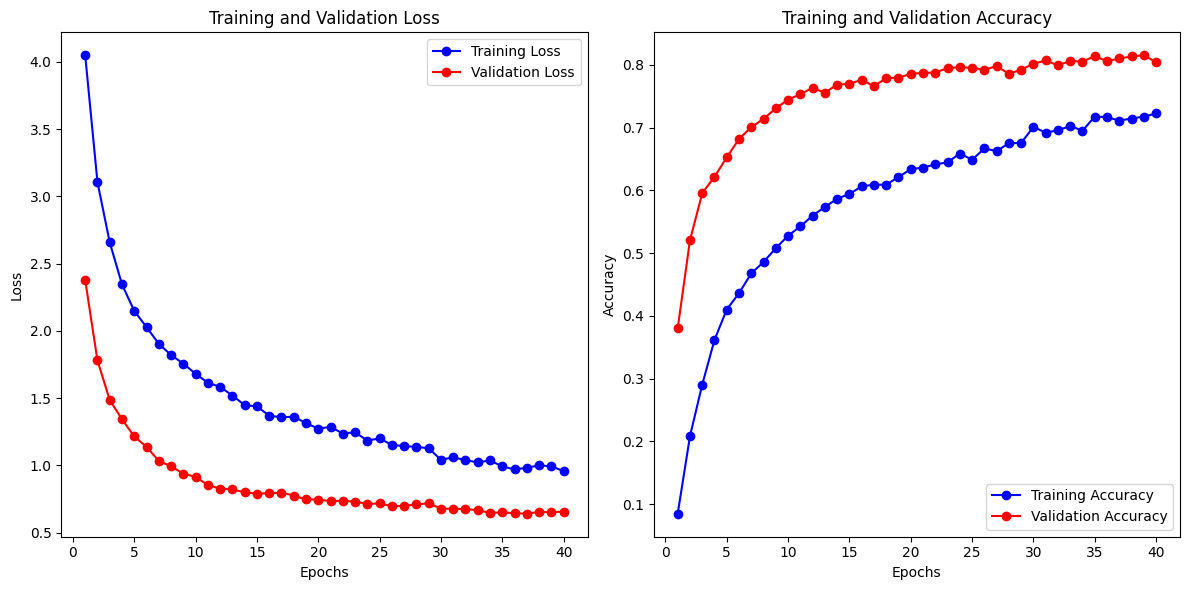

In [15]:
# Function to plot training and validation metrics
def plot_full_training_history(full_history):
    epochs = range(1, len(full_history['loss']) + 1)

    # Plot Loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, full_history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, full_history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, full_history['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs, full_history['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the combined training history
plot_full_training_history(full_history)